In [ ]:
!pip install torch torchvision torchaudio
!pip install transformers[torch]
!pip install pandas scikit-learn matplotlib seaborn
!pip install pyvi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

--- Bắt đầu trực quan hóa dữ liệu ---


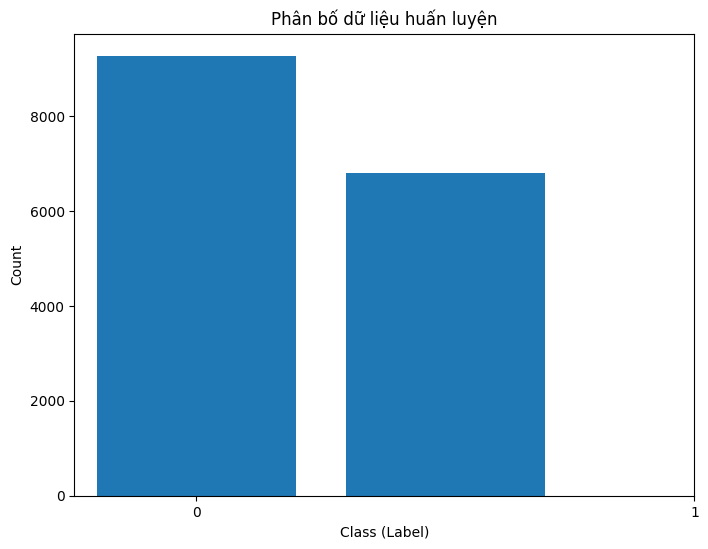

Đã lưu biểu đồ phân bố dữ liệu vào data_distribution.png
--- Kết thúc trực quan hóa dữ liệu ---

--- Tải và chuẩn bị dữ liệu cho việc huấn luyện ---

--- Bắt đầu quá trình huấn luyện PhoBERT ---
Đang xử lý văn bản...
Số lượng lớp (nhãn): 2
Chia dữ liệu train/validation...
Khởi tạo mô hình PhoBERT để phân loại...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Bắt đầu quá trình Fine-tuning PhoBERT...
Epoch 1/3
----------


In [ ]:
import pandas as pd
import joblib
import numpy as np
import matplotlib.pyplot as plt
import re
import torch
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from pyvi import ViTokenizer # Thư viện quan trọng để tách từ tiếng Việt

# =====================================================================================
# PHẦN 1: TẢI VÀ TRỰC QUAN HÓA DỮ LIỆU (Giữ nguyên logic của bạn)
# =====================================================================================

PATH_DATA = "/content/train.crash"

class DataSource:
    def _load_raw_data(self, filename, is_train=True):
        a = []
        b = []
        regex = 'train_' if is_train else 'test_'
        try:
            with open(filename, "r", encoding="utf-8") as file:
                for line in file:
                    if regex in line:
                        if a:
                            b.append(a)
                        a = [line]
                    elif line.strip():
                        a.append(line)
        except FileNotFoundError:
            print(f"Lỗi: Không tìm thấy file {filename}")
            return []
        if a:
            b.append(a)
        return b[1:] if b and regex in b[0][0] else b

    def _create_row(self, sample_lines, is_train=True):
        d = {}
        if not sample_lines:
            return None
        d['id'] = sample_lines[0].strip()
        if is_train:
            if len(sample_lines) < 2:
                 print(f"Cảnh báo: Sample không đủ dòng: {sample_lines}")
                 return None
            review_lines = sample_lines[1:-1]
            label_line = sample_lines[-1].strip()
            if not label_line.isdigit():
                print(f"Cảnh báo: Nhãn không hợp lệ cho sample {d['id']}: '{label_line}'.")
                review_lines = sample_lines[1:]
                d['label'] = -1
            else:
                d['label'] = int(label_line)
        else:
            review_lines = sample_lines[1:]
        d['review'] = "".join(clause.strip() for clause in review_lines)
        if not d['review']:
            print(f"Cảnh báo: Review rỗng cho ID {d['id']}")
        return d

    def load_data(self, filename, is_train=True):
        raw_samples = self._load_raw_data(filename, is_train)
        processed_rows = [self._create_row(s, is_train) for s in raw_samples if self._create_row(s, is_train)]
        if not processed_rows:
            print(f"Không có dữ liệu nào được tải từ {filename}. Vui lòng kiểm tra định dạng file.")
        return processed_rows

def visualize_data(file_path):
    ds = DataSource()
    data_list = ds.load_data(file_path, is_train=True)
    if not data_list:
        print("Không có dữ liệu để trực quan hóa.")
        return
    train_data = pd.DataFrame(data_list)
    if 'label' not in train_data.columns or train_data.empty:
        print("Dữ liệu không có cột 'label' hoặc rỗng sau khi tải.")
        return
    valid_labels = train_data[train_data['label'] != -1]['label']
    if valid_labels.empty:
        print("Không có nhãn hợp lệ để trực quan hóa.")
        return
    plt.figure(figsize=(8,6))
    plt.hist(valid_labels.to_numpy(), bins=len(valid_labels.unique()), rwidth=0.8, align='left')
    plt.xlabel("Class (Label)")
    plt.ylabel("Count")
    plt.title("Phân bố dữ liệu huấn luyện")
    plt.xticks(sorted(valid_labels.unique()))
    plt.savefig('data_distribution.png')
    plt.show()
    print("Đã lưu biểu đồ phân bố dữ liệu vào data_distribution.png")

# =====================================================================================
# PHẦN 2: TIỀN XỬ LÝ VĂN BẢN (Cập nhật cho PhoBERT)
# =====================================================================================

class Util:
    dict_replace = {
        "ship": "vận chuyển","shop": "cửa hàng","m": "mình","mik":"mình","ko":"không","k":"không","kh":"không","khong":"không","kg":"không","khg":"không","tl":"trả lời",
"rep":"trả lời","r":"rồi","fb":"facebook","face":"faceook","thanks":"cảm ơn","thank":"cảm ơn","tks":"cảm ơn","tk":"cảm ơn","ok":"tốt","oki":"tốt","okie":"tốt","sp":"sản phẩm",
"dc":"được","vs":"với","đt":"điện thoại","thjk":"thích","thik":"thích","qá":"quá","trể":"trễ","bgjo":"bao giờ","h":"giờ","qa":"quá","dep":"đẹp","xau":"xấu","ib":"nhắn tin",
"cute":"dễ thương","sz":"size","good":"tốt","god":"tốt","bt":"bình thường"
    }

    def remove_redundant(self, text):
        if not isinstance(text, str): return ""
        return re.sub(r'([A-Z])\1+', lambda m: m.group(1).upper(), text, flags=re.IGNORECASE)

    def normalize(self, text):
        if not isinstance(text, str): return ""
        text = text.lower()
        words = text.split()
        words = [self.dict_replace.get(w, w) for w in words]
        return " ".join(words)

    def process_text(self, text):
        text = self.remove_redundant(text)
        text = self.normalize(text)
        # BƯỚC QUAN TRỌNG: Tách từ tiếng Việt cho PhoBERT
        text = ViTokenizer.tokenize(text)
        return text

# =====================================================================================
# PHẦN 3: HUẤN LUYỆN MÔ HÌNH PHO BERT (Thay thế hoàn toàn)
# =====================================================================================

# Tạo một lớp Dataset cho PyTorch
class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        label = self.labels[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Lớp chính để điều khiển quá trình huấn luyện
class PhobertTrainer:
    def __init__(self, model_name="vinai/phobert-base-v2", max_len=256, batch_size=16, epochs=3):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.max_len = max_len
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.util = Util()

    def create_data_loader(self, df, tokenizer, max_len, batch_size):
        ds = SentimentDataset(
            texts=df.review.to_numpy(),
            labels=df.label.to_numpy(),
            tokenizer=tokenizer,
            max_len=max_len
        )
        return DataLoader(ds, batch_size=batch_size, num_workers=2)

    def train_epoch(self, model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
        model = model.train()
        losses = []
        correct_predictions = 0
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            labels = d["labels"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )
            loss = outputs.loss
            logits = outputs.logits

            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        return correct_predictions.double() / n_examples, np.mean(losses)

    def eval_model(self, model, data_loader, loss_fn, device, n_examples):
        model = model.eval()
        losses = []
        correct_predictions = 0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for d in data_loader:
                input_ids = d["input_ids"].to(device)
                attention_mask = d["attention_mask"].to(device)
                labels = d["labels"].to(device)

                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )
                loss = outputs.loss
                logits = outputs.logits

                _, preds = torch.max(logits, dim=1)
                correct_predictions += torch.sum(preds == labels)
                losses.append(loss.item())

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = correct_predictions.double() / n_examples
        f1 = f1_score(all_labels, all_preds, average='weighted')
        return accuracy, np.mean(losses), f1, all_labels, all_preds

    def run_training(self, df):
        print("Đang xử lý văn bản...")
        df['review'] = df['review'].apply(self.util.process_text)

        # Lấy số lượng nhãn duy nhất
        num_labels = df.label.nunique()
        print(f"Số lượng lớp (nhãn): {num_labels}")

        print("Chia dữ liệu train/validation...")
        df_train, df_val = train_test_split(df, test_size=0.2, random_state=42, stratify=df.label)

        train_data_loader = self.create_data_loader(df_train, self.tokenizer, self.max_len, self.batch_size)
        val_data_loader = self.create_data_loader(df_val, self.tokenizer, self.max_len, self.batch_size)

        print("Khởi tạo mô hình PhoBERT để phân loại...")
        model = AutoModelForSequenceClassification.from_pretrained(self.model_name, num_labels=num_labels)
        model = model.to(self.device)

        optimizer = AdamW(model.parameters(), lr=2e-5)
        total_steps = len(train_data_loader) * self.epochs
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=0,
            num_training_steps=total_steps
        )
        loss_fn = torch.nn.CrossEntropyLoss().to(self.device)

        print("Bắt đầu quá trình Fine-tuning PhoBERT...")
        for epoch in range(self.epochs):
            print(f'Epoch {epoch + 1}/{self.epochs}')
            print('-' * 10)

            train_acc, train_loss = self.train_epoch(
                model, train_data_loader, loss_fn, optimizer, self.device, scheduler, len(df_train)
            )
            print(f'Train loss {train_loss} accuracy {train_acc}')

            val_acc, val_loss, val_f1, _, _ = self.eval_model(
                model, val_data_loader, loss_fn, self.device, len(df_val)
            )
            print(f'Val loss {val_loss} accuracy {val_acc} F1-score {val_f1}')
            print()

        print("Huấn luyện hoàn tất.")

        # Đánh giá cuối cùng và vẽ ma trận nhầm lẫn
        print("Đánh giá trên tập validation và vẽ ma trận nhầm lẫn...")
        _, _, _, y_test, y_pred = self.eval_model(model, val_data_loader, loss_fn, self.device, len(df_val))

        class_labels = sorted(df['label'].unique())
        cm = confusion_matrix(y_test, y_pred, labels=class_labels)

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                    xticklabels=class_labels, yticklabels=class_labels)
        plt.title("Confusion Matrix on Validation Set")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()

        return model, self.tokenizer

# =====================================================================================
# PHẦN 4: PHÂN LOẠI CÂU MỚI (Cập nhật)
# =====================================================================================

def classify_sentence(sentence, model, tokenizer, device, max_len=256):
    util = Util()
    processed_text = util.process_text(sentence)

    encoding = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=max_len,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        _, prediction = torch.max(logits, dim=1)

    # Giả định nhãn 0 là tích cực, 1 là tiêu cực.
    # Bạn có thể tạo một map rõ ràng hơn nếu cần: label_map = {0: 'Tích cực', 1: 'Tiêu cực'}
    if prediction.item() == 1:
        return "Bình luận tiêu cực!"
    elif prediction.item() == 0:
        return "Bình luận tích cực!"
    else:
        return f"Bình luận được phân loại là: {prediction.item()}"

# =====================================================================================
# PHẦN 5: HÀM MAIN ĐIỀU KHIỂN CHÍNH
# =====================================================================================

if __name__ == '__main__':
    # 1. Khởi tạo DataSource và trực quan hóa
    ds = DataSource()
    print("--- Bắt đầu trực quan hóa dữ liệu ---")
    visualize_data(PATH_DATA)
    print("--- Kết thúc trực quan hóa dữ liệu ---\n")

    # 2. Tải và làm sạch dữ liệu
    print("--- Tải và chuẩn bị dữ liệu cho việc huấn luyện ---")
    raw_data_list = ds.load_data(PATH_DATA, is_train=True)
    if not raw_data_list:
        print("Không thể tải dữ liệu, chương trình kết thúc.")
    else:
        data_df = pd.DataFrame(raw_data_list)
        # Loại bỏ các hàng có nhãn không hợp lệ hoặc review rỗng
        data_df = data_df[data_df['label'] != -1]
        data_df = data_df.dropna(subset=['review'])
        data_df = data_df[data_df['review'].str.strip() != '']

        if data_df.empty:
            print("Không có dữ liệu hợp lệ sau khi làm sạch.")
        else:
            # 3. Huấn luyện mô hình
            print("\n--- Bắt đầu quá trình huấn luyện PhoBERT ---")
            trainer = PhobertTrainer(epochs=3) # Có thể tăng số epochs nếu cần
            trained_model, trained_tokenizer = trainer.run_training(data_df)

            # 4. Lưu model đã huấn luyện
            model_save_path = '/content/phobert_sentiment_model.pkl'
            trained_model.save_pretrained(model_save_path)
            trained_tokenizer.save_pretrained(model_save_path)
            print(f"\nĐã lưu model và tokenizer vào thư mục: {model_save_path}")

            # 5. Vòng lặp kiểm tra phân loại câu mới
            print("\n--- Bắt đầu kiểm tra phân loại câu ---")
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

            while True:
                text_input = input("Nhập câu để kiểm tra cảm xúc (hoặc nhập 'exit' để thoát): ").strip()
                if text_input.lower() == "exit":
                    break
                if not text_input:
                    print("Vui lòng nhập một câu.")
                    continue

                classification_result = classify_sentence(
                    text_input,
                    trained_model,
                    trained_tokenizer,
                    device
                )
                print(f"Kết quả: {classification_result}")

    print("\n--- Chương trình kết thúc ---")